In [15]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import sys
import math

import gym
import pickle

In [16]:
import pickle

In [17]:
GAMMA = 0.9
ALPHA = 0.1
EPSILON = 0.15

In [18]:
env = gym.make('CartPole-v0')

In [19]:
observation = env.reset()

In [20]:
next_state, reward, done, _ = env.step(env.action_space.sample())

In [21]:
bins = np.zeros((4,10))
bins[0] = np.linspace(-4.8, 4.8, 10)
bins[1] = np.linspace(-5, 5, 10)
bins[2] = np.linspace(-.418, .418, 10)
bins[3] = np.linspace(-5, 5, 10)

In [22]:
def discretize_one_state(c_state): 
    d_state = np.zeros(4)
    for i in range(4):
        d_state[i] = bins[i][np.digitize(c_state[i], bins[i])]
    return tuple(d_state)

In [23]:
def initialise_Q():
    Q = {}
    for i in range(10):
        for j in range(10):
            for k in range(10):
                for l in range(10):
                    state_tuple = (bins[0][i] , bins[1][j], bins[2][k], bins[3][l])
                    Q[state_tuple] = {}
                    Q[state_tuple][0] = 0.0
                    Q[state_tuple][1] = 0.0
    return Q

In [24]:
def get_best_action(state, Q):
    best_value = float('-inf')
    best_action = 1
    for a in range(env.action_space.n):
        if Q[state][a] > best_value:
            best_value = Q[state][a] 
            best_action = a
    return best_action , best_value

In [25]:
def train_one_episode(Q, eps):
    start_state = env.reset()
    episode_len = 0
    r = 0.0
    done = False
    current_state = discretize_one_state(start_state)
    while not done:
        episode_len += 1
        if np.random.uniform() < eps:
            action = env.action_space.sample()
        else:
            action, val = get_best_action(current_state, Q)
        
        state, reward, done, _ = env.step(action)
        r += reward
        
        if done and episode_len < 200:
            reward = -375
        
        next_state = discretize_one_state(state)
        #print ("l: %d , s:%d , a:%d , sp:%d"%(episode_len, current_state, action, next_state))
        #print(current_state, action, next_state)
        next_action, q_max = get_best_action(next_state, Q)
        Q[current_state][action] += ALPHA * (reward + (GAMMA * q_max) - Q[current_state][action])
        current_state = next_state
        action = next_action
    
    return r, episode_len    

In [26]:
def train_multiple_episodes(no_of_episodes = 100):
    Q = initialise_Q()
    eps = 0.50
    
    length = []
    reward = []
    for i in range(no_of_episodes):
        ep_reward, ep_length = train_one_episode(Q, eps)
        if i%2000 == 0:
            print("Episode: %d, Length %d Reward: %d"%(i, ep_length, ep_reward))
        length.append(ep_length)
        reward.append(ep_reward)
        eps = 0.9 * eps
    env.close()
    return length, reward, Q

In [27]:
def plot_avg_reward(totalrewards,title='Running Average',save=False,name='result'):
    fig=plt.figure()
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Reward")
    plt.grid()
    if save:
        plt.savefig(name+'.png',bbox_inches='tight')
    else:
        plt.show()

Episode: 0, Length 9 Reward: 9
Episode: 2000, Length 200 Reward: 200
Episode: 4000, Length 200 Reward: 200
Episode: 6000, Length 200 Reward: 200
Episode: 8000, Length 200 Reward: 200
Episode: 10000, Length 200 Reward: 200
Episode: 12000, Length 200 Reward: 200
Episode: 14000, Length 200 Reward: 200
Episode: 16000, Length 200 Reward: 200
Episode: 18000, Length 200 Reward: 200


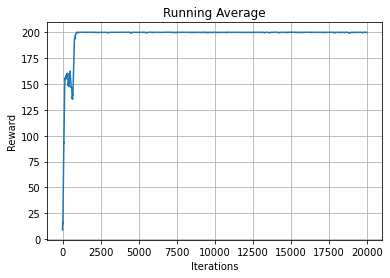

In [28]:
length, reward, Q = train_multiple_episodes(no_of_episodes = 20000)

plot_avg_reward(reward)

In [29]:
print("Saving the expert policy")
filename = 'expert_policy_cartpole'
outfile = open(filename,'wb')
pickle.dump(Q,outfile)
outfile.close()

Saving the expert policy


In [30]:
def run_trained_policy(Q, iterations = 1000, bins = 10):
    tot_reward = []
    steps = []
    for i in range(iterations):
        state = env.reset()
        r = 0.0
        done = False
        while not done:
            current_state = discretize_one_state(state)
            action, val = get_best_action(current_state, Q)
            state, reward, done, _ = env.step(action)
            r += reward
        tot_reward.append(r)
    env.close()
    return tot_reward

In [31]:
policy_reward = run_trained_policy(Q, iterations = 10000)

Text(0, 0.5, 'Frequency')

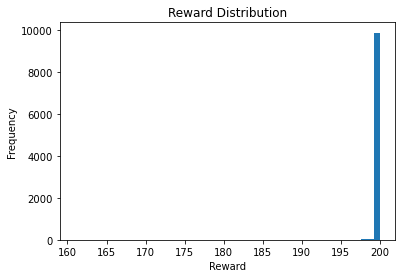

In [32]:
plt.hist(policy_reward,bins=50)
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")

# IRL PART

In [33]:
def sigmoid(state):
    sig = []
    for s in state:
        sig.append(1/(1+math.exp(-s)))
    return np.array(sig)

In [34]:
def irl_feature_expectations(Q, N = 100000):
    stateSum = np.zeros(4)
    for i in range(N):
        state = env.reset()
        done = False
        ep_length = 0
        while not done:
            current_state = discretize_one_state(state)
            action, val = get_best_action(current_state, Q)
            state, reward, done, _ = env.step(action)
            
            state_sig = sigmoid(state)
            stateSum += (GAMMA**ep_length) * state_sig
            
            ep_length += 1
    featureExpectation = stateSum/N
    
    print("FeatureExpectation: ",featureExpectation)
    return featureExpectation

In [35]:
def irl_train_one_episode(Q, eps, weight):
    start_state = env.reset()
    episode_len = 0
    r = 0.0
    done = False
    current_state = discretize_one_state(start_state)
    
    while not done:
        episode_len += 1
        if np.random.uniform() < eps:
            action = env.action_space.sample()
        else:
            action, val = get_best_action(current_state, Q)
        
        state, reward, done, _ = env.step(action)
        
        next_state = discretize_one_state(state)
        state = sigmoid(state)
        
        reward = np.dot(weight, state)
        r += reward
        
        if done and episode_len < 200:
            reward = -1
        
        next_action, q_max = get_best_action(next_state, Q)
        Q[current_state][action] += ALPHA * (reward + (GAMMA * q_max) - Q[current_state][action])
        current_state = next_state
        action = next_action
    
    return r, episode_len  

In [36]:
def irl_train_multiple_episodes(weight, no_of_episodes = 10000):
    Q = initialise_Q()
    eps = 0.50
    
    length = []
    reward = []
    for i in range(no_of_episodes):
        ep_reward, ep_length = irl_train_one_episode(Q, eps, weight)
        length.append(ep_length)
        reward.append(ep_reward)
        eps = 0.9 * eps
    print("Avg Length of episode: %d"%(np.average(length)))
    print("Standard Deviation: %d"%(np.std(length)))
    return length, reward, Q

In [37]:
expertExpectation = irl_feature_expectations(Q , N = 100000)

FeatureExpectation:  [4.97141768 4.83954559 5.08342247 5.45189592]


In [ ]:
def irl_training():
    eps = 0.05
    N = 20
    
    weight = []
    featureExpectation = []
    featureExpectation_ = []
    estimated_Q = []
    margin = []
    avg_ep_length = []
    
    for i in range(N):
        if i == 0:
            init_Q = initialise_Q()
            featureExpectation.append(irl_feature_expectations(init_Q))
            
            estimated_Q.append(init_Q)
            weight.append(np.zeros(4))
            margin.append(1)
            
        else:
            if i == 1:
                featureExpectation_.append(featureExpectation[i-1])
                weight.append(expertExpectation - featureExpectation[i-1])
                margin.append(norm((expertExpectation - featureExpectation_[i-1]),2))
                
                print("Margin: ",margin[i])
                print("Weight: ",weight[i])
                
            else:
                A = featureExpectation_[i-2]
                B = featureExpectation[i-1] - A
                C = expertExpectation - featureExpectation_[i-2]
                
                featureExpectation_.append(A+(np.dot(B,C)/np.dot(B,B))*(B))
                
                weight.append(expertExpectation - featureExpectation[i-1])
                margin.append(norm((expertExpectation - featureExpectation_[i-1]),2))
                
                print("Margin: ",margin[i])
                print("Weight: ",weight[i])
                
            if (margin[i] <= eps):
                break
                
            ep_length, ep_reward, estimated_Q_new = irl_train_multiple_episodes(weight[i])
            estimated_Q.append(estimated_Q_new)
            avg_ep_length.append(ep_length)
            featureExpectation.append(irl_feature_expectations(estimated_Q[i]))
            
    return estimated_Q, avg_ep_length, featureExpectation, margin

In [ ]:
estimated_Q, avg_ep_length, featureExpectation, margin = irl_training()

In [40]:
print("export trained IRL model...")
filename = 'learnedQ'
outfile = open(filename,'wb')
pickle.dump(estimated_Q, outfile)
outfile.close()

export trained IRL model...


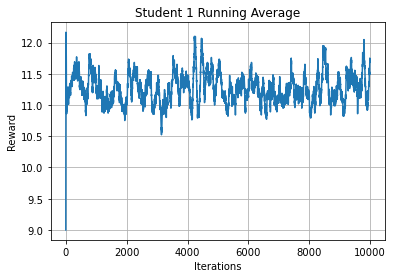

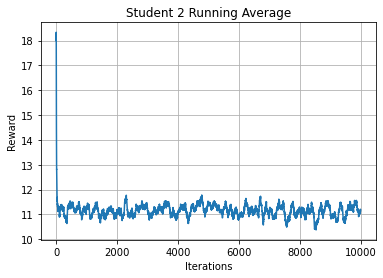

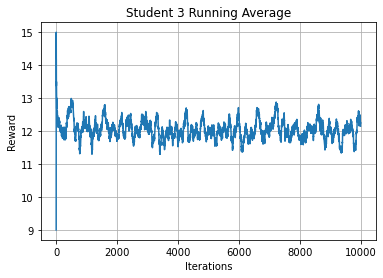

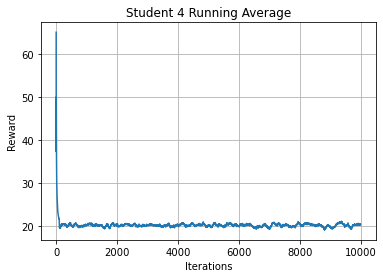

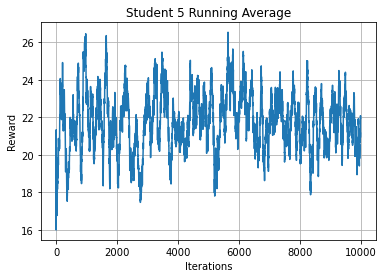

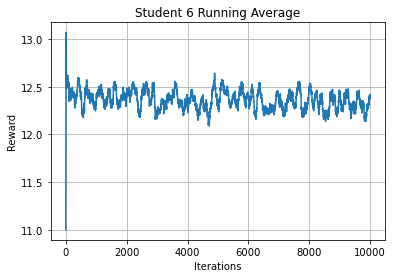

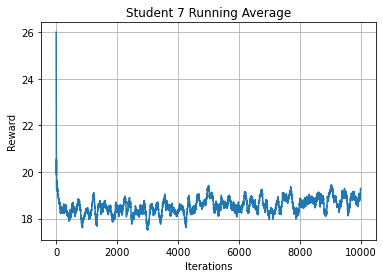

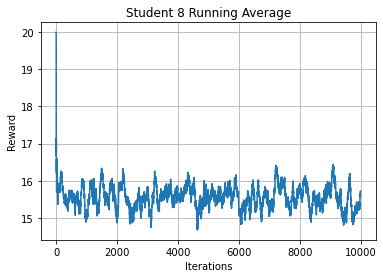

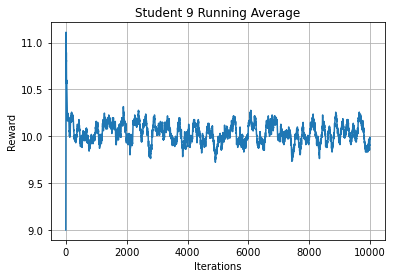

In [41]:
for i in range(0,len(avg_ep_length)):
    title="Iteration "+str(i+1)+" Running Average"
    plot_avg_reward(avg_ep_length[i],title=title,save=True,name=title)

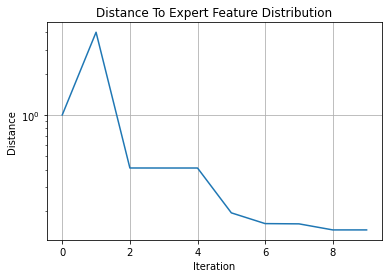

In [42]:
plt.plot(margin)
plt.title("Distance To Expert Feature Distribution")
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.yscale("log")
plt.grid()
plt.savefig("Distance To Expert Feature Distribution")

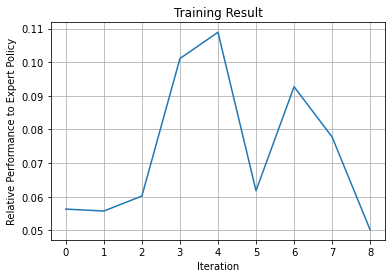

In [43]:
#showing the performance of each student relative to the performance of the expert
iteration=[]
relativePerformance=[]
studentPerformance=[]

for i in avg_ep_length:
    studentPerformance.append(np.average(i))

for i in range(np.size(studentPerformance)):
    iteration.append(i)
    relativePerformance.append(studentPerformance[i]/200)
    
plt.plot(iteration,relativePerformance)
plt.xlabel("Iteration")
plt.ylabel("Relative Performance to Expert Policy")
plt.title("Training Result")
plt.grid()
plt.savefig("Distance To Expert Feature Distribution")

In [ ]:
# class DQL():
#     ''' Deep Q Neural Network class. '''
#     def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
#             self.criterion = torch.nn.MSELoss()
#             self.model = torch.nn.Sequential(
#                             torch.nn.Linear(state_dim, hidden_dim),
#                             torch.nn.LeakyReLU(),
#                             torch.nn.Linear(hidden_dim, hidden_dim*2),
#                             torch.nn.LeakyReLU(),
#                             torch.nn.Linear(hidden_dim*2, action_dim)
#                     )
#             self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
# def update(self, state, y):
#         """Update the weights of the network given a training sample. """
#         y_pred = self.model(torch.Tensor(state))
#         loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()
# def predict(self, state):
#         """ Compute Q values for all actions using the DQL. """
#         with torch.no_grad():
#             return self.model(torch.Tensor(state))

In [ ]:
print("Save IRL model")
filename = 'IRL_model'
outfile = open(filename,'wb')
pickle.dump(estimated_Q, outfile)
outfile.close()